# Assignment 3: Character-Level Recurrent Neural Network by PyTorch

In this assignment, you are required to implement Character-Level RNN just as we have learned in the class. However, the difference is we use another dataset in this assignment.

Read through the tutorial [here](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) that builds a char-rnn that is used to classify names by their country of origin, which is introduced in the class. It is recommended that you can reproduce the tutorial’s results on the provided name dataset before moving on (notebook for Lecture 7), since the neural network architectures remain largely the same. Make sure you try your best to understand the dimensions of each layer (e.g. which ones can stay the same, and which are hyperparameters for us to tweak).

The process will be broken down into the following steps:
>1. Code implementation. (20 marks)
2. Experimentation and analysis (80 marks)

In [ ]:
#Download and unzip files
!pip3 install scikit-learn
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_test.txt
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_val.zip
!wget http://computational-linguistics-class.org/homework/nn-lms/cities_train.zip
!sudo apt-get install unzip
!unzip cities_val.zip 
!unzip cities_train.zip 
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
!pip3 install https://download.pytorch.org/whl/cu100/torch-1.0.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torch torchvision
  
import torch
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#Verfiy file download
!head train/af.txt
!printf "\n"
!head val/af.txt
!printf "\n"
!head cities_test.txt
!printf "\n"
#Verify CUDA acceleration should print cuda:0
print(device)

## Code Implementation (20 marks)

**You should implement all the following functions and you are not allowed to delete any of them. Of course you can add more functions based on this skeleton.**

In [68]:
#main_classify.py
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score
import unicodedata
import os
import random
'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
n_categories=len(languages)
baseDir='data\citiesnames'


def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

'''
Returns the words of the language specified by reading it from the data folder
Returns the validation data if train is false and the train data otherwise.
Return: A nx1 array containing the words of the specified language
'''
def getWords(baseDir, lang, train = True):
    if(train == True):
        dir=os.path.join(baseDir,'cities_train\\train',lang+'.txt')
    else:
        dir=os.path.join(baseDir,'cities_val\\val',lang+'.txt')
    lines = open(dir, encoding='utf-8').read().strip().split('\n')
    l=[unicodeToAscii(line) for line in lines]
    return l
    

'''
Returns a label corresponding to the language
For example it returns an array of 0s for af
Return: A nx1 array as integers containing index of the specified language in the "languages" array
'''
def getLabels(lang, length):
    label=[]
    index=languages.index(lang)
    for i in range(length):
        label.append(index)
    return label

'''
Returns all the laguages and labels after reading it from the file
Returns the validation data if train is false and the train data otherwise.
You may assume that the files exist in baseDir and have the same names.
Return: X, y where X is nx1 and y is nx1
'''
def readData(baseDir, train=True):
    data=[]
    label=[]
    for lang in languages:
        x=getWords(baseDir, lang, train)
        y=getLabels(lang,len(x))
        data.extend(x)
        label.extend(y)
    return data,label
x,y=readData(baseDir, train=True)


'''
Convert a line/word to a pytorch tensor of numbers
Refer the tutorial in the spec
Return: A tensor corresponding to the given line
'''
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

'''
Returns the category/class of the output from the neural network
Input: Output of the neural networks (class probabilities)
Return: A tuple with (language, language_index)
        language: "af", "cn", etc.
        language_index: 0, 1, etc.
'''
def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return languages[category_i], category_i
'''
Get a random input output pair to be used for training 
Refer the tutorial in the spec
'''
def random_training_pair(X, y):
    r=random.randint(0, len(X) - 1)
    category=languages[y[r]]
    line = X[r]
    category_tensor=torch.tensor([y[r]], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

'''
Input: trained model, a list of words, a list of class labels as integers
Output: a list of class labels as integers
'''
def predict(model, x, y):
    with torch.no_grad():
        hidden = model.init_hidden()
        category_tensor=torch.tensor([y], dtype=torch.long)
        line_tensor = line_to_tensor(x)
        for j in range(line_tensor.size()[0]):
                output, hidden = model(line_tensor[j], hidden)
        guess, guess_i = category_from_output(output)    
    return guess,guess_i

'''
Input: trained model, a list of words, a list of class labels as integers
Output: The accuracy of the given model on the given input X and target y
'''
def calculateAccuracy(model, X, y):
    num=0
    confusion = torch.zeros(n_categories, n_categories)
    for i in range(len(X)):
        guess,guess_i=predict(model,X[i],y[i])
        category=languages[y[i]]
        confusion[y[i]][guess_i] += 1
        if guess==category:
            num=num+1
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()
    return num/len(X),confusion
# Xv,yv=readData(baseDir, train=False)
# print(calculateAccuracy(rnn, Xv, yv))

'''
Train the model for one epoch/one training word.
Ensure that it runs within 3 seconds.
Input: X and y are lists of words as strings and classes as integers respectively
Returns: You may return anything
'''
def trainOneEpoch(model, criterion,optimizer,X, y):
    hidden = model.init_hidden()

    optimizer.zero_grad()
    category, line, category_tensor, line_tensor = random_training_pair(X,y)
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
#     # Add parameters' gradients to their values, multiplied by learning rate
#     for p in model.parameters():
#         p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item(),category,line


def validation_loss(model,X,y):
    with torch.no_grad():
        loss=0
        for i in range(len(X)):
            hidden = model.init_hidden()
            category_tensor=torch.tensor([y[i]], dtype=torch.long)
            line_tensor = line_to_tensor(X[i])
            for j in range(line_tensor.size()[0]):
                output, hidden = model(line_tensor[j], hidden)
            loss = loss + criterion(output, category_tensor)
        return loss/len(X)   

    
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)
'''
Use this to train and save your classification model. 
Save your model with the filename "model_classify"
'''
def run(model,criterion,optimizer,X, y):
    start = time.time()
    current_loss = 0
    all_losses = []
    all_losses_v = []
    for iter in range(1, n_iters + 1):
        output, loss, category,line = trainOneEpoch(model,criterion,optimizer,X, y)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_v.append(validation_loss(model,Xv,yv))
            current_loss = 0
    
    #torch.save(model, "rnn.pth")
    return all_losses,all_losses_v


In [39]:
#models.py
import torch.nn as nn
from torch.autograd import Variable
import torch

import torch.nn.functional as F

'''
Please add default values for all the parameters of __init__.
'''
class CharRNNClassify(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNNClassify, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden=None):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

## Experimentation and Analysis (80 marks)

Complete the following analysis on the city names dataset.

1. Write code to output accuracy on the validation set (10 marks).  Use a confusion matrix plot to support your answer (10 marks).

accuracy on the validation：0.490000


D:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


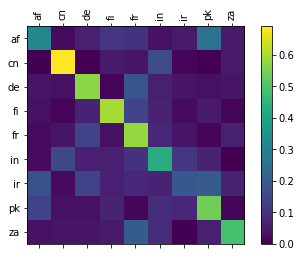

In [22]:
Xv,yv=readData(baseDir, train=False)
acc,confusion=calculateAccuracy(rnn, Xv, yv)
print('accuracy on the validation：%f' % (acc))
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

2. Periodically compute the loss on the validation set, and create a plot with the training and validation loss as training progresses (20 marks).

In [29]:
import time
import math
import torch.optim as optim
n_iters = 150000
print_every = 10000
plot_every = 1000
learning_rate = 0.001
criterion = nn.NLLLoss()
# Keep track of losses for plotting
X,y=readData(baseDir, train=True)
Xv,yv=readData(baseDir, train=False)
n_hidden = 128
rnn = CharRNNClassify(n_letters, n_hidden, n_categories)
optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
all_losses,all_losses_v = run(rnn,criterion,optimizer,X, y)

10000 6% (0m 52s) 2.0966 grattery / af ✗ (fr)
20000 13% (1m 41s) 2.0381 ruskeasanta / pk ✗ (fi)
30000 20% (2m 34s) 2.2391 painda / fi ✗ (pk)
40000 26% (3m 31s) 1.5338 ratsula / fi ✓
50000 33% (4m 26s) 1.6515 noamundi / cn ✗ (in)
60000 40% (5m 19s) 1.5180 soiniemi / in ✗ (fi)
70000 46% (6m 12s) 0.4194 babar shah harai / pk ✓
80000 53% (7m 3s) 2.2804 lairoka / fi ✗ (ir)
90000 60% (7m 54s) 1.5788 zamblefla / za ✓
100000 66% (8m 47s) 0.3668 rettersheim / de ✓
110000 73% (9m 40s) 1.7694 liel platone muzas centrs / fr ✗ (za)
120000 80% (10m 33s) 1.3990 dino sammun / in ✓
130000 86% (11m 25s) 0.9517 nazar kalle / za ✓
140000 93% (12m 18s) 0.1347 jingzihao / cn ✓
150000 100% (13m 12s) 1.2001 as safarqiyah / fi ✗ (af)


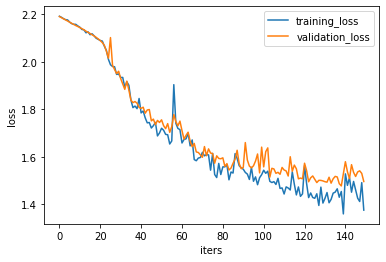

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.plot(all_losses,label='training_loss')
ax.plot(all_losses_v,label='validation_loss')
ax.set_xlabel('iters')
ax.set_ylabel('loss')
ax.legend()

3. Experiment with the learning rate. You can try a few different learning rates and observe how this affects the loss. Another common practice is to drop the learning rate when the loss has plateaued. Use plots to explain your experiments and their effects on the loss (20 marks).

In [71]:
rnn1 = CharRNNClassify(n_letters, n_hidden, n_categories)
n_iters = 180000
print_every = 5000
optimizer1 = optim.SGD(rnn1.parameters(), lr=0.0005)
#scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
all_losses1,all_losses_v1 = run(rnn1,criterion,optimizer1,X, y)


5000 2% (0m 9s) 2.1923 frenchman cove / cn ✗ (fr)
10000 5% (0m 19s) 2.1481 blangiel / ir ✗ (fr)
15000 8% (0m 37s) 2.1462 kowndalan / cn ✗ (af)
20000 11% (1m 1s) 2.1495 virtsanoja / pk ✗ (fi)
25000 13% (1m 25s) 2.2304 bussieresprespionsat / af ✗ (fr)
30000 16% (1m 49s) 2.1813 chak one hundred thirtysix / fr ✗ (ir)
35000 19% (2m 13s) 2.1451 baleh bazar / af ✗ (za)
40000 22% (2m 38s) 2.2822 friedrichsfehn / cn ✗ (fr)
45000 25% (3m 2s) 2.1556 meylaki / pk ✗ (ir)
50000 27% (3m 25s) 1.8700 ningshenhsien / cn ✓
55000 30% (3m 49s) 2.0918 mato dentro / fi ✗ (de)
60000 33% (4m 13s) 2.3723 nanyangli / pk ✗ (cn)
65000 36% (4m 38s) 1.6821 dracysurouanne / fr ✓
70000 38% (5m 1s) 2.1978 kuchicheklu / cn ✗ (ir)
75000 41% (5m 25s) 0.8960 ilkendorfer lehden / de ✓
80000 44% (5m 49s) 1.8064 rossiniere / fr ✗ (in)
85000 47% (6m 14s) 2.3132 pina de montalgrao / cn ✗ (de)
90000 50% (6m 38s) 1.2905 egundela / de ✓
95000 52% (7m 4s) 0.9141 halkai ghazlana / pk ✓
100000 55% (7m 29s) 1.4939 darne / fr ✓
105000 

In [56]:
rnn2 = CharRNNClassify(n_letters, n_hidden, n_categories)
optimizer2 = optim.SGD(rnn2.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10000, gamma=0.5)
n_iters = 150000
def run1(model,criterion,optimizer,X, y):
    start = time.time()
    current_loss = 0
    all_losses = []
    all_losses_v = []
    for iter in range(1, n_iters + 1):
        output, loss, category,line = trainOneEpoch(model,criterion,optimizer,X, y)
        current_loss += loss
        scheduler.step()
        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = category_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            all_losses_v.append(validation_loss(model,Xv,yv))
            current_loss = 0
    
    #torch.save(rnn, "rnn2.pth")
    return all_losses,all_losses_v
all_losses2,all_losses_v2 = run1(rnn2,criterion,optimizer2,X, y)

5000 3% (0m 10s) 2.4195 zangtun / cn ✗ (za)
10000 6% (0m 21s) 1.1524 delpuri / de ✓
15000 10% (0m 31s) 1.4323 llanddeusant / fr ✗ (de)
20000 13% (0m 42s) 1.9593 moskhofiton / ir ✗ (fi)
25000 16% (0m 52s) 2.2136 serefiye / fr ✗ (fi)
30000 20% (1m 3s) 1.6907 agha miri / pk ✗ (ir)
35000 23% (1m 13s) 0.0496 zalsazhye / za ✓
40000 26% (1m 23s) 1.6684 donfins / in ✗ (fi)
45000 30% (1m 33s) 2.1543 riroda / de ✗ (ir)
50000 33% (1m 43s) 1.7130 codfish park / ir ✗ (fi)
55000 36% (1m 54s) 1.1340 saintjuliendejonzy / in ✗ (fr)
60000 40% (2m 4s) 1.8157 dekhdana / de ✗ (af)
65000 43% (2m 15s) 0.6135 goth ilias khodio / pk ✓
70000 46% (2m 25s) 0.2972 rouvroylesmerles / fr ✓
75000 50% (2m 36s) 1.8592 jafo / fi ✗ (af)
80000 53% (2m 47s) 1.6625 gura cainarului / ir ✗ (in)
85000 56% (2m 58s) 0.6317 eloyes / fr ✓
90000 60% (3m 8s) 0.1370 filikha / fi ✓
95000 63% (3m 18s) 2.7472 tirentang / in ✗ (ir)
100000 66% (3m 28s) 1.0924 picketts crossing / in ✓
105000 70% (3m 39s) 2.6283 izvoru din fata / fi ✗ (in)


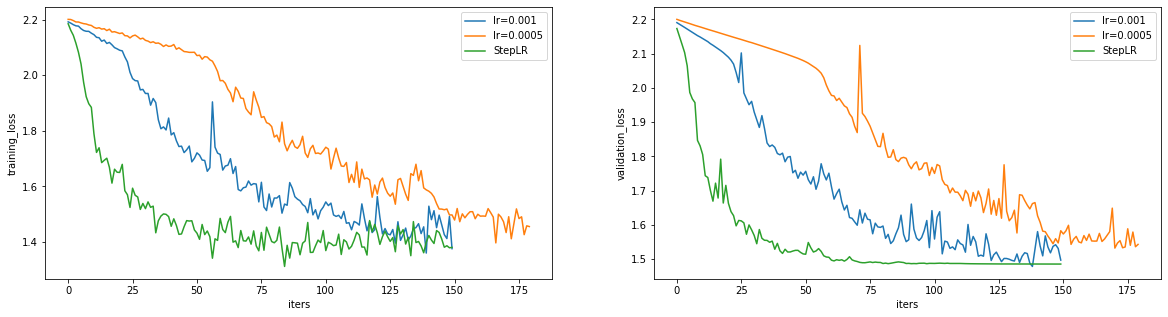

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
ax1.plot(all_losses,label='lr=0.001')
ax1.plot(all_losses1,label='lr=0.0005')
ax1.plot(all_losses2,label='StepLR')

ax2.plot(all_losses_v,label='lr=0.001')
ax2.plot(all_losses_v1,label='lr=0.0005')
ax2.plot(all_losses_v2,label='StepLR')
ax1.set_xlabel('iters')
ax1.set_ylabel('training_loss')
ax2.set_xlabel('iters')
ax2.set_ylabel('validation_loss')
ax1.legend()
ax2.legend()

在这一小问中，我一共做了三个实验：   
1，学习率等于0.001，训练了150000轮  
2，学习率等于0.0005，训练了180000轮  
3，用了PyTorch已经为我们封装好了的一个在训练过程中动态调整学习率的方法torch.optim.lr_scheduler.StepLR，我的设置是初始学习率等于0.005，每经过10000轮，学习率变为原来的一半，训练了150000轮。  
上面这两个图分别为这三个实验在训练集上的loss和在验证集上的loss的变化。从上图中可以看出，学习率随着轮次的变化不断衰减时效果最好。

4. Experiment with the size of the hidden layer or the model architecture How does this affect validation accuracy (20 marks)?

In [75]:
n_iters = 150000
print_every = 10000
plot_every = 1000
learning_rate = 0.001
criterion = nn.NLLLoss()
rnn3 = CharRNNClassify(n_letters, 64, n_categories)
rnn4 = CharRNNClassify(n_letters, 256, n_categories)
rnn5 = CharRNNClassify(n_letters, 512, n_categories)
optimizer3 = optim.SGD(rnn3.parameters(), lr=learning_rate)
optimizer4 = optim.SGD(rnn4.parameters(), lr=learning_rate)
optimizer5 = optim.SGD(rnn5.parameters(), lr=learning_rate)
all_losses3,all_losses_v3 = run(rnn3,criterion,optimizer3,X, y)
all_losses4,all_losses_v4 = run(rnn4,criterion,optimizer4,X, y)
all_losses5,all_losses_v5 = run(rnn5,criterion,optimizer5,X, y)
acc1,_=calculateAccuracy(rnn3, Xv, yv)
acc2,_=calculateAccuracy(rnn4, Xv, yv)
acc3,_=calculateAccuracy(rnn5, Xv, yv)

10000 6% (0m 16s) 2.1604 kondehha / za ✗ (af)
20000 13% (0m 33s) 2.3883 zatsen / cn ✗ (za)
30000 20% (0m 50s) 2.2002 chak one hundred sixtyfour nb / cn ✗ (pk)
40000 26% (1m 7s) 1.7137 country garden estates / fr ✗ (de)
50000 33% (1m 24s) 1.6699 zastavnoye / za ✓
60000 40% (1m 42s) 1.3575 owrak / af ✓
70000 46% (1m 59s) 0.6479 chishuchi / cn ✓
80000 53% (2m 16s) 1.0988 staryy zaamin / za ✓
90000 60% (2m 33s) 1.1592 filimons village / fi ✓
100000 66% (2m 50s) 0.8335 fikre / fi ✓
110000 73% (3m 7s) 2.5852 kali quzi / za ✗ (ir)
120000 80% (3m 24s) 1.9599 deh three hundred sixtyeight a / pk ✗ (de)
130000 86% (3m 41s) 1.2376 siahpetaw / af ✓
140000 93% (3m 58s) 3.0359 eggenpoint / in ✗ (de)
150000 100% (4m 15s) 1.0863 oberleuken / fr ✗ (de)
10000 6% (0m 26s) 2.0219 seh darak / af ✓
20000 13% (0m 54s) 2.2441 shamia / fi ✗ (af)
30000 20% (1m 21s) 1.6460 timaryine / in ✓
40000 26% (1m 49s) 2.8984 sirinkoy / in ✗ (ir)
50000 33% (2m 17s) 2.9584 broad fields / de ✗ (fi)
60000 40% (2m 44s) 2.0949 m

In [80]:
print('the size of the hidden layer = 128, accuracy on the validation：%f' % (acc))
print('the size of the hidden layer = 64, accuracy on the validation：%f' % (acc1))
print('the size of the hidden layer = 256, accuracy on the validation：%f' % (acc2))
print('the size of the hidden layer = 512, accuracy on the validation：%f' % (acc3))


the size of the hidden layer = 128, accuracy on the validation：0.490000
the size of the hidden layer = 64, accuracy on the validation：0.488889
the size of the hidden layer = 256, accuracy on the validation：0.467778
the size of the hidden layer = 512, accuracy on the validation：0.491111


从上面的实验我们可以看出，当隐藏层尺寸为128和512时效果最好，在验证集上的平均精度最高。其实改变隐藏层的尺寸精度变化不是很大，感觉要提高精度，要改变网络结构，用更加复杂的网络去训练。